In [2]:
# Boring preliminaries
from __future__ import division
%pylab inline
import os
import regex as re
import math
import string
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [3]:
os.getcwd()

'C:\\Users\\pparker.KLASJ\\Desktop\\spellchecker-master'

### (1) Data: Text and Words

In [4]:
with open('big.txt', 'r') as myfile:
    TEXT=myfile.read().replace('\n', '')

len(TEXT)

568829

In [5]:
#tokenize words
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower()) 

In [6]:
tokens('This is: A test, 1, 2, 3, this is.')

['this', 'is', 'a', 'test', 'this', 'is']

In [7]:
WORDS = tokens(TEXT)
len(TEXT)

568829

In [8]:
print(WORDS[:10])

['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur']


### (2) Model: Bag of Words

In [9]:
# sample words
def sample(bag, n=10):
    "Sample a random n-word sentence from the model described by the bag of words."
    return ' '.join(random.choice(bag) for _ in range(n))

In [10]:
sample(WORDS)

'what conclusion which with then the beganit scatteredthroughout that very'

In [11]:
# look at word frequencies
Counter(tokens('Is this a test? It is a test!'))

Counter({'is': 2, 'this': 1, 'a': 2, 'test': 2, 'it': 1})

In [12]:
# word frequency
COUNTS = Counter(WORDS)
for w in tokens('the rare and neverbeforeseen words'):
    print(COUNTS[w], w)

4886 the
3 rare
2759 and
0 neverbeforeseen
41 words


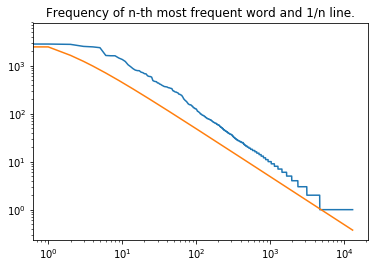

In [13]:
M = COUNTS['the']
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
plot([c for (w, c) in COUNTS.most_common()])
plot([M/i for i in range(1, len(COUNTS)+1)])

### (3) Task: Spelling Correction

In [14]:
def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

In [15]:
def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [16]:
def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [17]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [18]:
print(edits0('wird'))

{'wird'}


In [19]:
print(edits1('wird'))

{'wrid', 'lwird', 'woird', 'witrd', 'wir', 'wirmd', 'owird', 'wcird', 'wiid', 'wxird', 'wiru', 'wipd', 'fird', 'wirod', 'wisd', 'wirrd', 'wirld', 'wqrd', 'wmird', 'oird', 'wird', 'ywird', 'wfird', 'wikrd', 'wircd', 'iwird', 'wimrd', 'wirf', 'wirtd', 'wlrd', 'wdird', 'wirc', 'wkrd', 'wiurd', 'wprd', 'wbrd', 'wirsd', 'wirb', 'wirdk', 'wnrd', 'wirt', 'wjird', 'wirv', 'wirdy', 'wwird', 'wrird', 'wirqd', 'wimd', 'wiqd', 'awird', 'twird', 'whird', 'wtird', 'wiard', 'wirdv', 'wiyrd', 'wirdx', 'uwird', 'wbird', 'hird', 'wirw', 'bird', 'wiad', 'wiri', 'wirdf', 'wied', 'wirg', 'wpird', 'wild', 'wirq', 'weird', 'eird', 'xird', 'wyrd', 'wvird', 'wuird', 'bwird', 'waird', 'wgrd', 'wyird', 'wifd', 'wiyd', 'kird', 'wixrd', 'wirdm', 'zird', 'wirdl', 'wzrd', 'wirdo', 'wiqrd', 'wirjd', 'witd', 'xwird', 'wirz', 'wisrd', 'wixd', 'cwird', 'wirdc', 'word', 'wicd', 'gwird', 'wiwrd', 'wirxd', 'aird', 'wirdq', 'wiry', 'wiprd', 'wgird', 'wirdu', 'wira', 'nird', 'wijd', 'jwird', 'wirp', 'wierd', 'uird', 'winrd',

In [20]:
print(len(edits2('wird')))

24254


In [21]:
print(list(map(correct, tokens('Speling errurs in somethink. Whutever; unusuel misteakes everyware?'))))

['seeing', 'errors', 'in', 'something', 'whatever', 'unusual', 'mistaken', 'everyway']


In [22]:
def correct_text(text):
    "Correct all the words within a text, returning the corrected text."
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    "Spell-correct word in match, and preserve proper upper/lower/title case."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Return the case-function appropriate for text: upper, lower, title, or just str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [23]:
correct_text('Speling Errurs IN somethink. Whutever; unusuel misteakes?')

'Seeing Errors IN something. Whatever; unusual mistaken?'

### (4) Theory: From Counts to Probabilities of Word Sequences

In [24]:
def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(counter.values())
    return lambda x: counter[x]/N

In [25]:
# P(W) Demo
sum_all = len(TEXT)
for w in tokens('"The" is most common word in English'):
    print("{0:.6f}".format((COUNTS[w]/sum_all)), w)

0.008590 the
0.001825 is
0.000130 most
0.000018 common
0.000065 word
0.002808 in
0.000016 english


In [26]:
def Pword(token):
    return (COUNTS[token]/sum_all)

def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(Pword(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

In [27]:
tests = ['this is a test', 
         'this is a unusual test',
         'this is a neverbeforeseen test']

for test in tests:
    print(Pwords(tokens(test)), test)

3.22774393910919e-14 this is a test
2.8371830014900703e-19 this is a unusual test
0.0 this is a neverbeforeseen test


### (5) Task: Word Segmentation

In [28]:
def memo(f):
    "Memoize function f, whose args must all be hashable."
    cache = {}
    def fmemo(*args):
        if args not in cache:
            cache[args] = f(*args)
        return cache[args]
    fmemo.cache = cache
    return fmemo

In [29]:
max(len(w) for w in COUNTS)

26

In [30]:
def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

In [31]:
print(splits('word'))
print(splits('reallylongtext', 1, 4))

[('', 'word'), ('w', 'ord'), ('wo', 'rd'), ('wor', 'd'), ('word', '')]
[('r', 'eallylongtext'), ('re', 'allylongtext'), ('rea', 'llylongtext'), ('real', 'lylongtext')]


In [32]:
@memo
def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [33]:
segment('applicablestagesensorhealthcheck')

['applicable', 'stages', 'en', 's', 'or', 'health', 'check']

In [34]:
segment('applyuniversalfocusoffset')

['apply',
 'un',
 'i',
 've',
 'r',
 's',
 'a',
 'l',
 'f',
 'o',
 'c',
 'us',
 'off',
 'set']

In [75]:
decl = ('wheninthecourseofhumaneventsitbecomesnecessaryforonepeople' +
        'todissolvethepoliticalbandswhichhaveconnectedthemwithanother' +
        'andtoassumeamongthepowersoftheearththeseparateandequalstation' +
        'towhichthelawsofnatureandofnaturesgodentitlethem')

print(segment(decl))

['when', 'inthe', 'course', 'ofhuman', 'events', 'it', 'becomes', 'necessary', 'for', 'one', 'people', 'to', 'd', 'is', 'solve', 'the', 'political', 'bands', 'whichhave', 'connected', 'them', 'with', 'another', 'and', 'to', 'assume', 'amongthe', 'powersof', 'the', 'earth', 'the', 'separate', 'and', 'equal', 'station', 'to', 'which', 'the', 'laws', 'of', 'nature', 'and', 'of', 'nature', 's', 'go', 'den', 'title', 'them']


In [77]:
Pwords(segment(decl)), Pwords(segment(decl * 2))

(4.757196736294744e-191, 0.0)

In [78]:
segment('smallandinsignificant')

['small', 'and', 'in', 'sign', 'if', 'ican', 't']

In [79]:
segment('largeandinsignificant')

['large', 'and', 'in', 'sign', 'if', 'ican', 't']

In [80]:
print(Pwords(['large', 'and', 'insignificant']))
print(Pwords(['large', 'and', 'in', 'significant']))

0.0
0.0


### (6) Data: Mo' Data, Mo' Better

In [163]:
# put dictionary into string
with open('frequency_dictionary_en_82_765.txt', 'r') as myfile:
    DICT=myfile.read().replace('\n', '')

#add space between numbers and characters
DICT2 = re.sub(r'(\d+)(\w+)', r'\1 \2', DICT.lower())

#get list of word and count tuples
d_tup = re.findall(r'(\w+)\s(\d+)', DICT2)

#assign counter
C = Counter()
for pair in d_tup:
    C[pair[0]] = int(pair[1])

In [164]:
C.most_common(30)

[('the', 23135851162),
 ('of', 13151942776),
 ('and', 12997637966),
 ('to', 12136980858),
 ('a', 9081174698),
 ('in', 8469404971),
 ('for', 5933321709),
 ('is', 4705743816),
 ('on', 3750423199),
 ('that', 3400031103),
 ('by', 3350048871),
 ('this', 3228469771),
 ('with', 3183110675),
 ('i', 3086225277),
 ('you', 2996181025),
 ('it', 2813163874),
 ('not', 2633487141),
 ('or', 2590739907),
 ('be', 2398724162),
 ('are', 2393614870),
 ('from', 2275595356),
 ('at', 2272272772),
 ('as', 2247431740),
 ('your', 2062066547),
 ('all', 2022459848),
 ('have', 1564202750),
 ('new', 1551258643),
 ('more', 1544771673),
 ('an', 1518266684),
 ('was', 1483428678)]